In [98]:
import sys
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from mmengine.config import Config
from opentad.datasets import build_dataset, build_dataloader
from opentad.datasets.base import SlidingWindowDataset, PaddingDataset, filter_same_annotation
from opentad.datasets.pku import PkuSlidingDataset, PkuPaddingDataset

sys.path.append(str(Path.cwd()))
print("lib import completed")

lib import completed


In [99]:
config_path = "configs/adatad/pku_mmd/e2e_pku_mmd_videomae_s_768x1_160_adapter copy.py"
cfg = Config.fromfile(config_path)
print("config file load")
print("path : {config_path}")
print("keys : {list(cfg.keys())}")


config file load
path : {config_path}
keys : {list(cfg.keys())}


In [101]:
if hasattr(cfg, "dataset"):
    dataset_cfg = cfg.dataset
    print(f"dataset_cfg keys: {list(dataset_cfg.keys())}")

    if hasattr(dataset_cfg, 'train'):
        train_cfg = dataset_cfg.train
        print(f"train_cfg settings")
        print(f"type : {train_cfg.get('type', 'Unknown')}")
        print(f"ann_file : {train_cfg.get('ann_file', 'Unknown')}")
        print(f"data path : {train_cfg.get('data_prefix', 'Unknown')}")
        print(f"pipelines : {len(train_cfg.get('pipeline', []))}")
else:
    print("dataset_cfg x")

dataset_cfg keys: ['train', 'val', 'test']
train_cfg settings
type : PkuPaddingDataset
ann_file : data/PKU-MMD/pku_train.json
data path : Unknown
pipelines : 13


In [102]:
cfg = Config.fromfile(config_path)

train_dataset = build_dataset(cfg.dataset.train)

train_loader = build_dataloader(
    train_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)

training subset: 831 videos


In [126]:
if 'train_dataset' in locals():
    sample = train_dataset[0]
    print(f"train dataset sample keys : {list(sample.keys())}")

    for key, value in sample.items():
        print(f"{key}")
        print(f"type: {type(value)}")

        if hasattr(value, 'shape'):
            print(f"shape: {value.shape}")
            print(f"data type: {value.dtype}")
            
    else:
        print(f"no dataset")

train dataset sample keys : ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']
inputs
type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 512, 160, 160])
data type: torch.uint8
masks
type: <class 'torch.Tensor'>
shape: torch.Size([512])
data type: torch.bool
gt_segments
type: <class 'torch.Tensor'>
shape: torch.Size([2, 2])
data type: torch.float32
gt_labels
type: <class 'torch.Tensor'>
shape: torch.Size([2])
data type: torch.int32
metas
type: <class 'dict'>
no dataset


In [141]:
cfg = Config.fromfile(config_path)

val_dataset = build_dataset(cfg.dataset.val)

val_loader = build_dataloader(
    val_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)

test_dataset = build_dataset(cfg.dataset.test)

test_loader = build_dataloader(
    test_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)
try:
    adatad_loader = build_dataloader(
        train_dataset,
        rank=0,
        world_size=1,
        batch_size=2,
        num_workers=0,
        shuffle=True,
        drop_last=False
    )
    for batch_idx, data_dict in enumerate(adatad_loader):
        if batch_idx == 0:
            print(f" build success")
            print(f" batch keys: {list(data_dict.keys())}")
            break
except Exception as e:
    print(f"Error : {e}")
    import traceback
    traceback.print_exc()
        

validation subset: 111 videos, truncated as 1958 windows.
testing subset: 132 videos, truncated as 2370 windows.
 build success
 batch keys: ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']


In [142]:
first_sample = train_dataset[0]
print(f"first sample metadata:")
for key, value in first_sample.items():
    if key not in ['inputs', 'masks', 'gt_segments', 'gt_labels']:
        print(f"{key}: {value}")

if 'video_name' in first_sample:
    print(f"video name: {first_sample['video_name']}")

if 'windows_start_frame' in first_sample:
    print(f"windows start frame: {first_sample['windows_start_frame']}")



if 'duration' in first_sample:
    print(f"duration: {first_sample['duration']}")

if 'fps' in first_sample:
    print(f"fps: {first_sample['fps']}")

if 'snippet_stride' in first_sample:
    print(f"snippet stride: {first_sample['snippet_stride']}")
    

first sample metadata:
metas: {'video_name': '0002-L', 'data_path': 'F:/dataset/pku-mmd/rgb', 'fps': 30.0, 'duration': 4462, 'snippet_stride': 1, 'window_size': 512, 'offset_frames': 0}


In [ ]:
def visualize_pku_batch_sample(data_dict, sample_idx: int = 0, title: str = "sample"):

    if "inputs" not in data_dict:
        print("no inputs");  return

    inputs = data_dict["inputs"].cpu()      
    sample_inputs = inputs[sample_idx]      


    if sample_inputs.dim() == 5:          
        sample_inputs = sample_inputs[:, 0]    
    elif sample_inputs.dim() != 4:       
        raise ValueError(f"Unexpected shape: {sample_inputs.shape}")

    C, T, H, W = sample_inputs.shape
    frame_idx = np.linspace(0, T - 1, 8, dtype=int)

 
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"{title} (sample {sample_idx})", fontsize=16)

    for k, fi in enumerate(frame_idx):
        r, c = divmod(k, 4)
        frame = sample_inputs[:, fi].permute(1, 2, 0).numpy()     
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        ax[r, c].imshow((frame * 255).astype("uint8"))
        ax[r, c].set_title(f"Frame {fi}")
        ax[r, c].axis("off")

    plt.tight_layout();  plt.show()

    if {"gt_segments", "gt_labels"} <= data_dict.keys():
        segs, lbls = data_dict["gt_segments"], data_dict["gt_labels"]
        print(f"\n[pku annotation info] sample {sample_idx}")
        if sample_idx < len(segs):
            for i, (seg, lab) in enumerate(zip(segs[sample_idx], lbls[sample_idx])):
                print(f"  #{i+1:02d}  label={lab.item():2d}  segment={seg.tolist()}")
        else:
            print("  no annotation")

    if "metas" in data_dict and sample_idx < len(data_dict["metas"]):
        meta = data_dict["metas"][sample_idx]
        print(f"\n[pku metadata] sample {sample_idx}")
        for k, v in meta.items():
            print(f"  {k}: {v}")

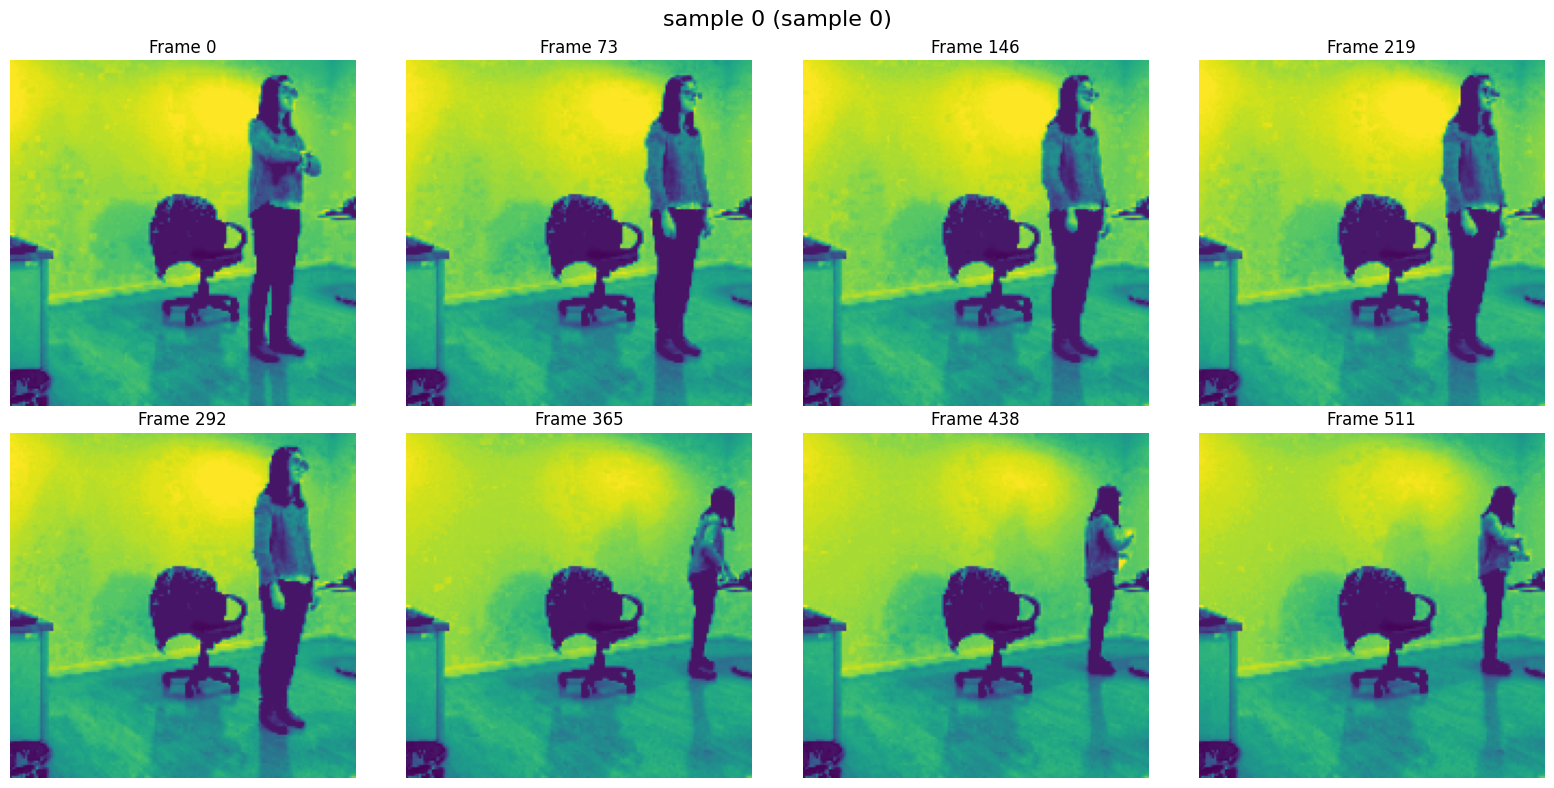


[pku annotation info] sample 0
  #01  label=43  segment=[43.0, 192.0]
  #02  label=16  segment=[194.0, 272.0]
  #03  label= 4  segment=[335.0, 401.0]

[pku metadata] sample 0
  video_name: 0154-L
  data_path: F:/dataset/pku-mmd/rgb
  fps: 30.0
  duration: 3572
  snippet_stride: 1
  window_size: 512
  offset_frames: 0


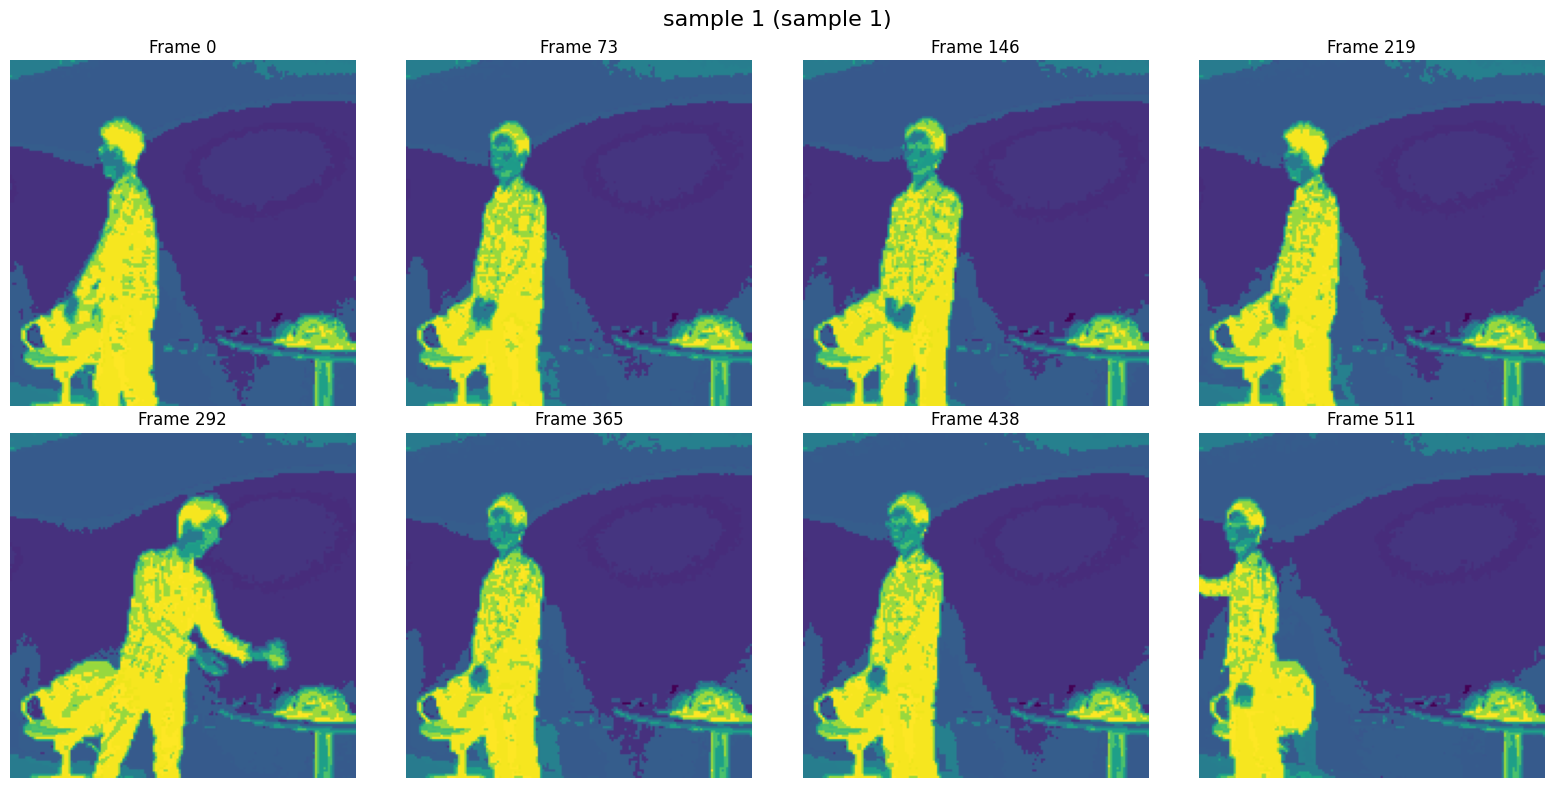


[pku annotation info] sample 1
  #01  label=17  segment=[79.0, 123.0]
  #02  label=25  segment=[275.0, 340.0]
  #03  label=26  segment=[480.0, 512.0]

[pku metadata] sample 1
  video_name: 0350-R
  data_path: F:/dataset/pku-mmd/rgb
  fps: 30.0
  duration: 1601
  snippet_stride: 1
  window_size: 512
  offset_frames: 0


In [146]:
if 'data_dict' in locals():
    visualize_pku_batch_sample(data_dict, sample_idx=0, title="sample 0")

    if data_dict['inputs'].shape[0] > 1:
        visualize_pku_batch_sample(data_dict, sample_idx=1, title="sample 1")

else:
    print("no batch data")